In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
import string
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
footprint_msa = pd.read_csv('../../../results/commercial-emissions.csv')
footprint_msa

,Unnamed: 0,County,Total Footprint Area (square feet),Ratio,GHG Emissions/MMTCO2e
0,0,New Haven-Milford,4.021517e+06,0.249936,0.955882
1,1,Hartford-East Hartford-Middletown,6.733395e+06,0.418479,1.600473
2,2,Bridgeport-Stamford-Norwalk,3.061254e+06,0.190256,0.727635
3,3,Rest of the state,2.274012e+06,0.141329,0.540514
4,4,Statewide,1.609018e+07,1.000000,3.824505


In [3]:
ct_emissions = pd.read_excel('../../../data/raw/Public GHG data 1990-2021.xlsx', sheet_name="Emission Totals")

In [4]:

# Extract the row corresponding to "Commercial"
commercial_row = ct_emissions[ct_emissions['Sector Emissions (MMTCO2e)'] == 'Commercial']

# Extract the columns from 1990 to 2021 estimate
columns_of_interest = [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
                      1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
                      2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
                      2017, 2018, 2019, 2020, '2021 (ESTIMATE)']

commercial_data = commercial_row[columns_of_interest]

# Define new name for the last column
new_last_column_name = '2021'

# Rename the last column
commercial_data.rename(columns={commercial_data.columns[-1]: new_last_column_name}, inplace=True)

commercial_data

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_27632\504994458.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commercial_data.rename(columns={commercial_data.columns[-1]: new_last_column_name}, inplace=True)


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
2,3.828568,3.662331,4.312955,3.843474,4.172272,3.8418,4.133427,4.30181,4.036593,4.290578,...,3.253953,3.580783,3.823815,4.343028,3.907677,3.92087,4.329612,4.196598,3.824505,4.00145


In [5]:
# Multiply each value in each row by 1, 2, and 3, and create new rows
multipliers = footprint_msa.loc[0:2, 'Ratio'].reset_index(drop=True)
multiplied_df = pd.concat([commercial_data * multiplier for multiplier in multipliers], ignore_index=True)

In [6]:
multipliers

0    0.249936
1    0.418479
2    0.190256
Name: Ratio, dtype: float64

In [7]:
data=multiplied_df.T

# Define new column names
new_column_names = ['New Haven commercial (MMTCO2e)', 'Hartford commercial (MMTCO2e)', 'Bridgeport commercial (MMTCO2e)']

# Assign new column names to the DataFrame
data.columns = new_column_names

data.index.name = 'year'


data.index = pd.to_datetime(data.index, format='%Y')
data.index.freq = 'AS'
df=data
df

,New Haven commercial (MMTCO2e),Hartford commercial (MMTCO2e),Bridgeport commercial (MMTCO2e)
year,,,
1990-01-01,0.956898,1.602174,0.728408
1991-01-01,0.915349,1.532607,0.696781
1992-01-01,1.077963,1.804879,0.820566
1993-01-01,0.960623,1.608412,0.731244
1994-01-01,1.042802,1.746006,0.793800
1995-01-01,0.960205,1.607711,0.730926
1996-01-01,1.033093,1.729751,0.786410
1997-01-01,1.075178,1.800215,0.818445
1998-01-01,1.008890,1.689228,0.767986


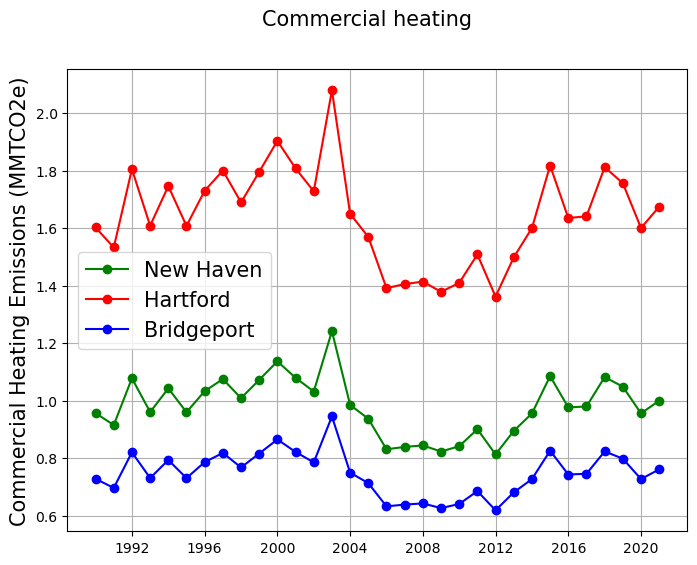

In [8]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Commercial heating',fontsize=15)
actual, = plt.plot(df.index, df['New Haven commercial (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford commercial (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport commercial (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Commercial Heating Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/commercial-heating-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [9]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [10]:
len(df_train)

26

In [11]:
len(df_test)

6

In [12]:
HEM_data = df['Hartford commercial (MMTCO2e)']
NHM_data = df['New Haven commercial (MMTCO2e)']
BSN_data = df['Bridgeport commercial (MMTCO2e)']


warnings.filterwarnings("ignore")

def performance_metric(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = performance_metric(test, pred_mean)
    
    # Calculate BIC and AIC
    bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse, bic

def gridsearch(data): 

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,8)
    d_values = range(1,3)
    q_values = range(0,8)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                bic_cv = []
            

                split_index = round(len(data)*0.8)
                train = data.iloc[:split_index].copy()
                test = data.iloc[split_index:].copy()

                mape, mae, rmse, bic = arima_prediction(train, test, order)
                mape_cv.append(mape)
                mae_cv.append(mae)
                rmse_cv.append(rmse)
                bic_cv.append(bic)
                    #aic_cv.append(aic)
                    


                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'BIC':bic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df


            
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_HEM_cv)

     p  d  q       MAPE       MAE      RMSE           BIC
0    0  1  0   7.966870  0.130946  0.150392 -1.434188e+01
1    0  1  1   4.719632  0.078673  0.084577 -1.559508e+01
2    0  1  2   6.680485  0.109792  0.127418 -1.193371e+01
3    0  1  3   8.319752  0.137402  0.153123 -7.610795e+00
4    0  1  4   7.211365  0.118713  0.135235 -3.272775e+00
..  .. .. ..        ...       ...       ...           ...
123  7  2  3  24.587192  0.411097  0.450201  1.799204e+01
124  7  2  4  16.068391  0.268037  0.287289  2.049193e+01
125  7  2  5  10.999332  0.186925  0.225552  1.856116e+09
126  7  2  6  36.198054  0.606666  0.656417  2.903910e+01
127  7  2  7   5.900302  0.098358  0.105721  2.604953e+01

[128 rows x 7 columns]


In [13]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_HEM=test_HEM.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_HEM.applymap(lambda x: f'{x:.3f}')
rounded_df

MAPE    MAE   RMSE      BIC
p d q                              
6 1 6  3.089  0.052  0.065   19.551
5 1 6  3.389  0.057  0.068   17.957
3 1 2  3.705  0.062  0.068   -1.837
0 1 1  4.720  0.079  0.085  -15.595
4 1 7  4.247  0.070  0.085   16.955
    6  4.496  0.074  0.085   15.137
6 1 7  4.066  0.067  0.090   19.238
3 1 5  4.841  0.081  0.095    6.512
1 1 0  5.144  0.085  0.097  -15.503
7 1 0  4.992  0.082  0.098    6.884

In [14]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_NHM=test_NHM.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_NHM.applymap(lambda x: f'{x:.3f}')
rounded_df

,,,MAPE,MAE,RMSE,BIC
p,d,q,,,,
4,1,3,3.215,0.032,0.035,-17.818
6,1,6,3.165,0.032,0.038,1.087
3,1,2,3.703,0.037,0.041,-24.515
4,1,6,3.630,0.036,0.042,-2.751
7,1,5,3.391,0.033,0.049,1.470
0,1,1,4.720,0.047,0.051,-39.304
4,1,7,4.537,0.045,0.051,0.846
7,1,6,4.469,0.044,0.055,5.100
3,1,5,4.841,0.048,0.057,-13.074


In [15]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_BSN = test_BSN.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_BSN.applymap(lambda x: f'{x:.3f}')
rounded_df

MAPE    MAE   RMSE      BIC
p d q                              
4 1 3  2.916  0.022  0.025  -29.576
5 1 6  3.235  0.025  0.028  -10.037
3 1 2  3.704  0.028  0.031  -36.520
5 1 7  2.945  0.023  0.032   -3.172
6 1 3  3.675  0.027  0.036  -17.784
0 1 1  4.720  0.036  0.038  -51.855
7 1 6  3.884  0.029  0.039   -5.087
    4  4.446  0.033  0.040   -7.235
4 1 6  4.331  0.033  0.040  -12.344
6 1 6  4.747  0.036  0.041  -10.624

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     Hartford commercial (MMTCO2e)   No. Observations:                   32
Model:                            ARIMA(4, 1, 3)   Log Likelihood                  19.139
Date:                           Wed, 08 May 2024   AIC                            -22.277
Time:                                   12:52:16   BIC                            -10.805
Sample:                               01-01-1990   HQIC                           -18.538
                                    - 01-01-2021   Scale                            0.015
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6856      1.463     -1.152      0.249      -4.554       1.183
ar.L2         -1.8132      0.856     -2.118      0.034      -3.491      -0.135
ar.L3         -1.5528      1.559     -0.996      0.319      -4.609       1.503
ar.L4         -0.4597      0.538     -0.854      0.393      -1.515       0.595
ma.L1          1.2163     10.949      0.111      0.912     -20.243      22.676
ma.L2          1.2304    108.816      0.011      0.991    -212.044     214.505
ma.L3          0.9799     94.854      0.010      0.992    -184.930     186.890
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.81   Prob(JB):                         0.92
Heteroskedasticity (H):               0.97   Skew:                            -0.18
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

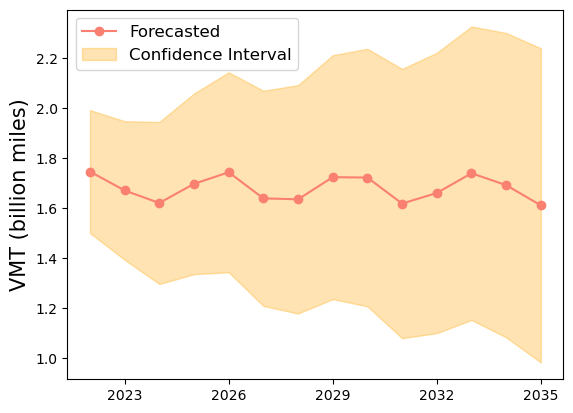

In [16]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= True, enforce_invertibility= True, concentrate_scale=True)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2022, 2022 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval

HEM_train = df_train['Hartford commercial (MMTCO2e)']
HEM_test = df_test['Hartford commercial (MMTCO2e)']
HEM_data = df['Hartford commercial (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-commercial.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(4,1,3),14, plot_file,'salmon','orange')
HEM_summary.summary()

In [17]:
HEM_summary.pvalues

ar.L1    0.249426
ar.L2    0.034208
ar.L3    0.319322
ar.L4    0.393108
ma.L1    0.911548
ma.L2    0.990978
ma.L3    0.991757
dtype: float64

In [18]:
def arima_test_data_performance_metrics(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= True, enforce_invertibility= True, concentrate_scale=True)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2022-len(test),2022)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    bic = res.bic
    

    return mae, rmse, mape,bic

HEM_train = df_train['Hartford commercial (MMTCO2e)']
HEM_test = df_test['Hartford commercial (MMTCO2e)']
mae, rmse, mape,bic = arima_test_data_performance_metrics(HEM_train, HEM_test,(4,1,3))
print(mae)
print(rmse)
print(mape)
print(bic)

0.08664533948387265
0.10066149906080309
5.2389758759719305
-1.6557705192462926


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:     New Haven commercial (MMTCO2e)   No. Observations:                   32
Model:                             ARIMA(4, 1, 3)   Log Likelihood                  35.120
Date:                            Wed, 08 May 2024   AIC                            -54.239
Time:                                    12:52:17   BIC                            -42.767
Sample:                                01-01-1990   HQIC                           -50.500
                                     - 01-01-2021   Scale                            0.005
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6875      1.401     -1.205      0.228      -4.433       1.058
ar.L2         -1.8157      0.820     -2.214      0.027      -3.423      -0.208
ar.L3         -1.5549      1.490     -1.043      0.297      -4.476       1.366
ar.L4         -0.4614      0.512     -0.901      0.368      -1.465       0.542
ma.L1          1.2173     12.149      0.100      0.920     -22.595      25.030
ma.L2          1.2310    120.169      0.010      0.992    -234.295     236.757
ma.L3          0.9807    104.881      0.009      0.993    -204.583     206.544
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.81   Prob(JB):                         0.92
Heteroskedasticity (H):               0.97   Skew:                            -0.17
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

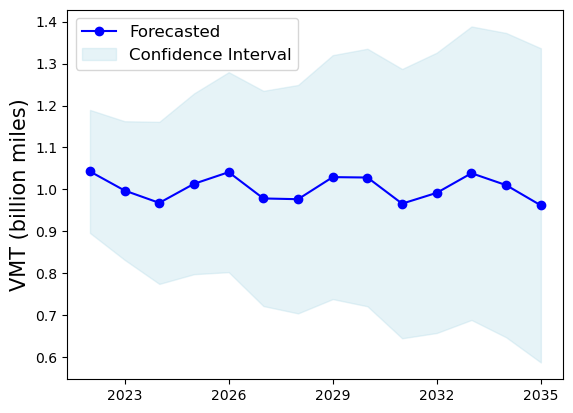

In [19]:
NHM_train = df_train['New Haven commercial (MMTCO2e)']
NHM_test = df_test['New Haven commercial (MMTCO2e)']
NHM_data = df['New Haven commercial (MMTCO2e)']
plot_file = '../../../figures/newhaven-forecast-emissions-commercial.png'  # File to save the plot

summary, NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data, NHM_test, (4,1,3),14, plot_file,'blue','lightblue')
summary.summary()

In [20]:
summary.pvalues

ar.L1    0.228391
ar.L2    0.026858
ar.L3    0.296746
ar.L4    0.367533
ma.L1    0.920187
ma.L2    0.991827
ma.L3    0.992540
dtype: float64

In [21]:
NHM_train = df_train['New Haven commercial (MMTCO2e)']
NHM_test = df_test['New Haven commercial (MMTCO2e)']
mae, rmse, mape,bic = arima_test_data_performance_metrics(NHM_train, NHM_test,(1,0,0))
print(mae, rmse, mape)

0.047695870571933564 0.052603832811645976 4.682610657744073


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     Bridgeport commercial (MMTCO2e)   No. Observations:                   32
Model:                              ARIMA(4, 1, 3)   Log Likelihood                  43.597
Date:                             Wed, 08 May 2024   AIC                            -71.194
Time:                                     12:52:17   BIC                            -59.722
Sample:                                 01-01-1990   HQIC                           -67.454
                                      - 01-01-2021   Scale                            0.003
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6896      1.058     -1.596      0.110      -3.764       0.385
ar.L2         -1.8173      0.638     -2.846      0.004      -3.069      -0.566
ar.L3         -1.5586      1.110     -1.404      0.160      -3.734       0.617
ar.L4         -0.4643      0.365     -1.273      0.203      -1.179       0.251
ma.L1          1.2277     19.672      0.062      0.950     -37.329      39.785
ma.L2          1.2336    195.215      0.006      0.995    -381.380     383.847
ma.L3          0.9914    172.174      0.006      0.995    -336.463     338.446
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.82   Prob(JB):                         0.92
Heteroskedasticity (H):               0.97   Skew:                            -0.18
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

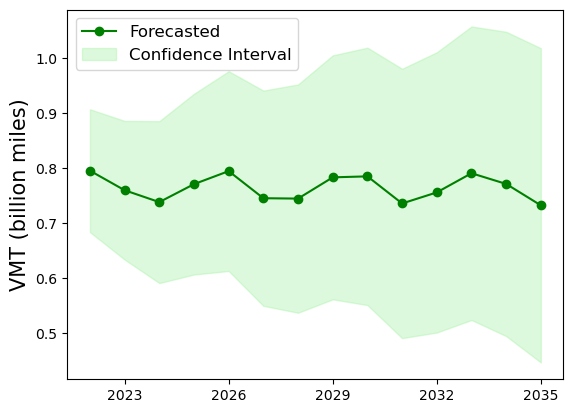

In [22]:
BSN_train = df_train['Bridgeport commercial (MMTCO2e)']
BSN_test = df_test['Bridgeport commercial (MMTCO2e)']
BSN_data = df['Bridgeport commercial (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-commercial.png'  # File to save the plot

summary, BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(4,1,3),14, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function
summary.summary()

In [23]:
summary.pvalues

ar.L1    0.110385
ar.L2    0.004421
ar.L3    0.160263
ar.L4    0.203023
ma.L1    0.950237
ma.L2    0.994958
ma.L3    0.995406
dtype: float64

In [24]:
mae, rmse, mape,bic = arima_test_data_performance_metrics(BSN_train, BSN_test,(1,0,0))
print(mae,rmse, mape)

0.03630711176089585 0.040043221518150894 4.682622731990865


In [25]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    train_conf_int = train_forecast.conf_int().iloc[1:]

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,train_conf_int
    

emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(4,1,3))
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(4,1,3))
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(4,1,3))
    

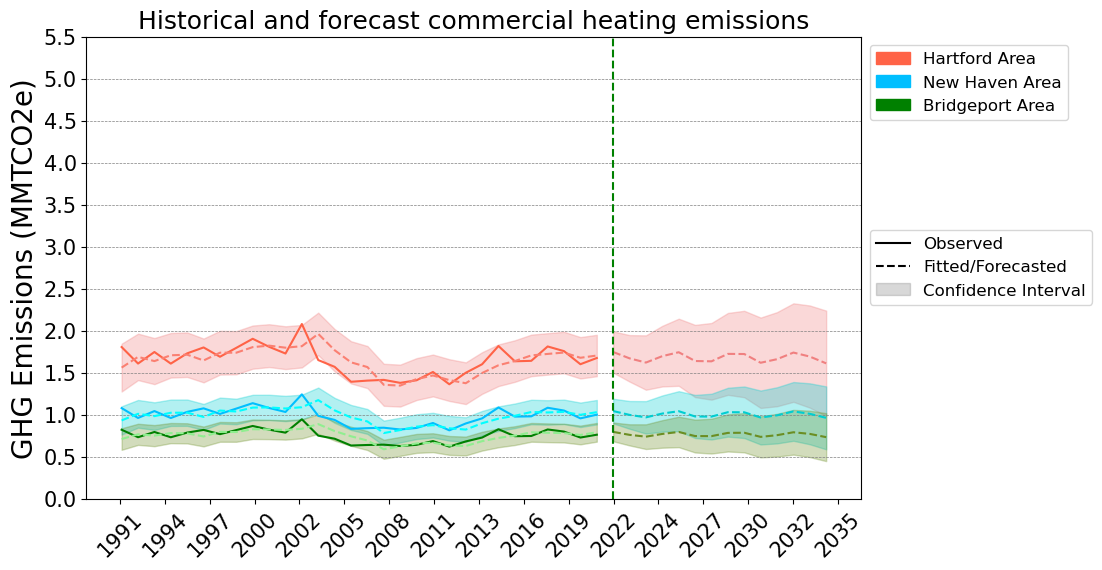

In [26]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[2:]
concatenated_predicted_HEM = emissions_train_HEM[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_HEM.index, concatenated_predicted_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

plt.plot(HEM_forecast.index, HEM_forecast, color='lightcoral', label='Hartford_Forecasted',linestyle='--')
plt.fill_between(HEM_forecast.index, HEM_confidence_interval.iloc[:, 0], HEM_confidence_interval.iloc[:, 1], color='lightcoral', alpha=0.3)
plt.fill_between(emissions_train_HEM[1:].index, train_conf_int_HEM.iloc[1:, 0], train_conf_int_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)


concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[2:]
concatenated_predicted_NHM = emissions_train_NHM[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='deepskyblue')
plt.plot(concatenated_predicted_NHM.index, concatenated_predicted_NHM, label='New Haven_Fitted', color='cyan', linestyle='--')

plt.plot(NHM_forecast.index, NHM_forecast, color='darkturquoise', label='New Haven_Forecasted',linestyle='--')
plt.fill_between(NHM_forecast.index, NHM_confidence_interval.iloc[:, 0], NHM_confidence_interval.iloc[:, 1], color='darkturquoise', alpha=0.3)
plt.fill_between(emissions_train_NHM[1:].index, train_conf_int_NHM.iloc[1:, 0], train_conf_int_NHM.iloc[1:, 1], color='darkturquoise', alpha=0.3)

concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[2:]
concatenated_predicted_BSN = emissions_train_BSN[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_BSN.index, concatenated_predicted_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

plt.plot(BSN_forecast.index, BSN_forecast, color='olivedrab', label='Bridgeport_Forecasted',linestyle='--')
plt.fill_between(BSN_forecast.index, BSN_confidence_interval.iloc[:, 0], BSN_confidence_interval.iloc[:, 1], color='olivedrab', alpha=0.3)
plt.fill_between(emissions_train_BSN[1:].index, train_conf_int_BSN.iloc[1:, 0], train_conf_int_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='deepskyblue', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Historical and forecast commercial heating emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=15, rotation=45) 
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')

# Hide the grid lines behind the line plot
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5, zorder=1)


max_y_value = 6
plt.yticks(np.arange(0, max_y_value, 0.5))


plt.savefig('../../../figures/commercial_forecast.png', dpi=600, bbox_inches='tight')

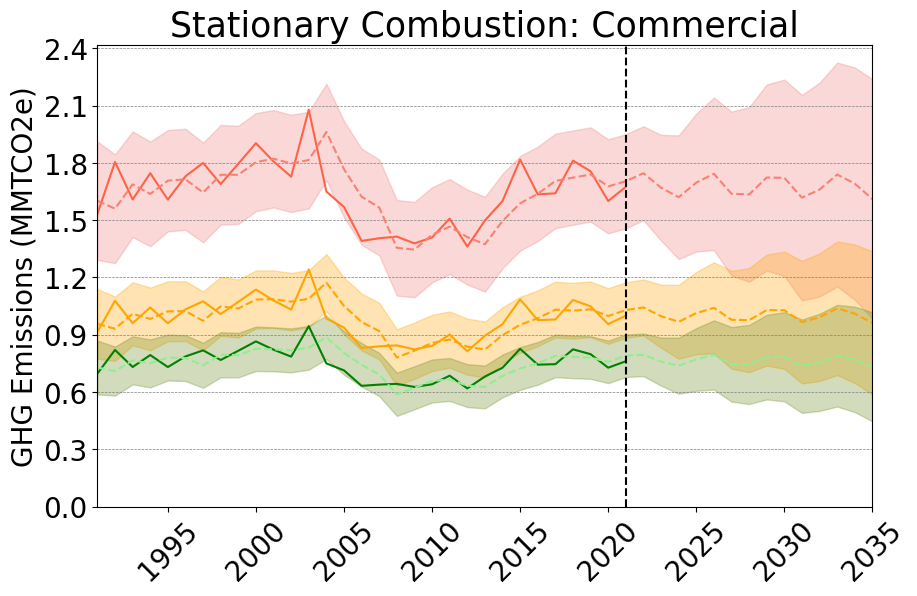

In [46]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM,HEM_forecast])

plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, HEM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_HEM.index, concatenated_confidence_interval_HEM.iloc[:, 0], concatenated_confidence_interval_HEM.iloc[:, 1], color='lightcoral', alpha=0.3)



concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM,NHM_forecast])

plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='orange')
plt.plot(concatenated_predicted_forecast_NHM.index, concatenated_predicted_forecast_NHM, label='New Haven_Fitted', color='orange', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, NHM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_NHM.index, concatenated_confidence_interval_NHM.iloc[:, 0], concatenated_confidence_interval_NHM.iloc[:, 1], color='orange', alpha=0.3)


concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN,BSN_forecast])

plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN.index, concatenated_predicted_forecast_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, BSN_confidence_interval])
plt.fill_between(concatenated_confidence_interval_BSN.index, concatenated_confidence_interval_BSN.iloc[:, 0], concatenated_confidence_interval_BSN.iloc[:, 1], color='olivedrab', alpha=0.3)


# # Legend for Colors (Locations)
# tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
# deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Area')
# green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
# color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# # Add the first legend manually to the plot
# plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
#plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Stationary Combustion: Commercial', fontsize=25)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=20, rotation=45) 
plt.yticks(fontsize=20)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2021, 1, 1), color='black', linestyle='--', label='Year 2022 (X-axis)')

# Hide the grid lines behind the line plot
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5, zorder=1)

plt.xlim(datetime.datetime(1991, 1, 1), datetime.datetime(2035, 1, 1))


max_y_value = 2.5
plt.yticks(np.arange(0, max_y_value, 0.3))


plt.savefig('../../../figures/commercial_forecast.png', dpi=600, bbox_inches='tight')

In [28]:
HEM_2022 = concatenated_observed_HEM[-1]
HEM_2035 = concatenated_predicted_forecast_HEM[-1]
HEM_per = (HEM_2022-HEM_2035)/HEM_2022*100 #%

In [29]:
NHM_2022 = concatenated_observed_NHM[-1]
NHM_2035 = concatenated_predicted_forecast_NHM[-1]
NHM_per = (NHM_2022-NHM_2035)/NHM_2022*100 #%

In [30]:
BSN_2022 = concatenated_observed_BSN[-1]
BSN_2035 = concatenated_predicted_forecast_BSN[-1]
BSN_per = (BSN_2022-BSN_2035)/BSN_2022*100 #% 

In [31]:
print(HEM_per,NHM_per,BSN_per)

3.807067058168825 3.818695777717003 3.827464529887503


In [32]:
concatenated_predicted_forecast_HEM.index = pd.to_datetime(concatenated_predicted_forecast_HEM.index)
concatenated_observed_HEM.index = pd.to_datetime(concatenated_observed_HEM.index)

# Extract data for the year 2021
HEM_2021 = concatenated_observed_HEM['2021'].values
HEM_2035 = concatenated_predicted_forecast_HEM['2035'].values


concatenated_predicted_forecast_NHM.index = pd.to_datetime(concatenated_predicted_forecast_NHM.index)
concatenated_observed_NHM.index = pd.to_datetime(concatenated_observed_NHM.index)

NHM_2021 = concatenated_observed_NHM['2021'].values
NHM_2035= concatenated_predicted_forecast_NHM['2035'].values


concatenated_predicted_forecast_BSN.index = pd.to_datetime(concatenated_predicted_forecast_BSN.index)
concatenated_observed_BSN.index = pd.to_datetime(concatenated_observed_BSN.index)

# Extract data for the year 2021
BSN_2021 = concatenated_observed_BSN['2021'].values
BSN_2035= concatenated_predicted_forecast_BSN['2035'].values


#how to calculate the difference: the difference equals the (old-new)/old
NHM_per = (NHM_2021-NHM_2035)/NHM_2021*100 #%

HEM_per = (HEM_2021-HEM_2035)/HEM_2021*100 #%

BSN_per = (BSN_2021-BSN_2035)/BSN_2021*100 #%

print(HEM_per,NHM_per,BSN_per)

[3.80706706] [3.81869578] [3.82746453]


In [33]:
df = pd.DataFrame({'Column1': -HEM_per, 'Column2': -NHM_per, 'Column3': -BSN_per})
df

,Column1,Column2,Column3
0,-3.807067,-3.818696,-3.827465


In [34]:
data = pd.DataFrame({'Column1': HEM_2021, 'Column2': HEM_2035, 'Column3': NHM_2021, 'Column4': NHM_2035, 'Column5': BSN_2021, 'Column6': BSN_2035})
data

,Column1,Column2,Column3,Column4,Column5,Column6
0,1.674521,1.610771,1.000107,0.961916,0.7613,0.732162


In [35]:
concatenated_confidence_interval_HEM['ME'] = (concatenated_confidence_interval_HEM.iloc[:, 1] - concatenated_confidence_interval_HEM.iloc[:, 0]) / 2
concatenated_confidence_interval_HEM

,lower Hartford commercial (MMTCO2e),upper Hartford commercial (MMTCO2e),ME
1991-01-01,1.292073,1.912274,0.310101
1992-01-01,1.275350,1.844923,0.284787
1993-01-01,1.411466,1.964578,0.276556
1994-01-01,1.363246,1.911911,0.274333
1995-01-01,1.441757,1.971965,0.265104
1996-01-01,1.448925,1.979050,0.265063
1997-01-01,1.384315,1.905966,0.260825
1998-01-01,1.476929,1.998534,0.260802
1999-01-01,1.480663,1.994997,0.257167
2000-01-01,1.546965,2.061159,0.257097


In [36]:
concatenated_confidence_interval_NHM['ME'] = (concatenated_confidence_interval_NHM.iloc[:, 1] - concatenated_confidence_interval_NHM.iloc[:, 0]) / 2
concatenated_confidence_interval_NHM

,lower New Haven commercial (MMTCO2e),upper New Haven commercial (MMTCO2e),ME
1991-01-01,0.774264,1.139531,0.182634
1992-01-01,0.763453,1.099703,0.168125
1993-01-01,0.845284,1.174964,0.164840
1994-01-01,0.818258,1.146981,0.164362
1995-01-01,0.865736,1.179739,0.157001
1996-01-01,0.866676,1.180334,0.156829
1997-01-01,0.818620,1.127474,0.154427
1998-01-01,0.894171,1.203025,0.154427
1999-01-01,0.885518,1.189796,0.152139
2000-01-01,0.932201,1.236425,0.152112


In [37]:
concatenated_confidence_interval_BSN['ME'] = (concatenated_confidence_interval_BSN.iloc[:, 1] - concatenated_confidence_interval_BSN.iloc[:, 0]) / 2
concatenated_confidence_interval_BSN

,lower Bridgeport commercial (MMTCO2e),upper Bridgeport commercial (MMTCO2e),ME
1991-01-01,0.587687,0.869130,0.140722
1992-01-01,0.581447,0.838082,0.128318
1993-01-01,0.640172,0.891736,0.125782
1994-01-01,0.624509,0.875829,0.125660
1995-01-01,0.660546,0.900697,0.120075
1996-01-01,0.657826,0.897654,0.119914
1997-01-01,0.622232,0.858304,0.118036
1998-01-01,0.677387,0.913450,0.118032
1999-01-01,0.677194,0.909737,0.116271
2000-01-01,0.710299,0.942842,0.116271
